In [2]:
import json
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyxray as xy
import xraydb
import uuid

from json_to_np import *

In [3]:
mac = hex(uuid.getnode())
print(f"MAC address: {mac}")

mac_dict = {'mac1': ['OfficePath'], '0x145afc4fe836': ['C://Users//schum//Documents//root_files_temp_storage', 'C://Users//schum//Documents//json_files_temp_storage'], '0x1a7dda7115': ['B://IBA//root', 'B://IBA//json']}
# Each mac adresse leads to a pair of paths, the first being the folder, 
# where the root files are, the second, where the json files are supposed to be stored
# root_path = mac_dict[mac][0]
json_path = mac_dict[mac][1]

MAC address: 0x1a7dda7115


In [32]:
def array_to_histo(data, mask_max = 1000):
    B = int(mask_max/0.12)
    plt.figure(figsize=(6,4), dpi=250)
    plt.hist(data[data <= mask_max], bins=B, color='firebrick', edgecolor='firebrick', zorder=2)
    plt.xlabel('Ekin')
    plt.ylabel('Counts')
    plt.yscale('log')
    # plt.ylim(0,500)
    plt.title("Histogramm von Ekin")
    plt.grid(True, zorder=1)
    plt.tight_layout()
    plt.show()

In [18]:
json_path = ".//json_files//Blade15_front30_PIXE;1.json"
data = json_to_np(json_path, json_field='Ekin')
data = data*1000
print(data)



True
[1.62636732 1.58775351 0.24990198 ... 0.41709482 5.01458991 4.56166005]
[1626.36731532 1587.75350636  249.9019798  ...  417.09481691 5014.58991452
 4561.66005447]


In [6]:
def full_transitions():
    matching = []

    for Z in range(1, 101):  # Elements from Hydrogen (Z=1) to Fermium (Z=100)
        element = xraydb.atomic_symbol(Z)

        # Get all known X-ray lines for the element
        lines = xraydb.xray_lines(element)


        for line_id, line in lines.items():
            line_energy = line.energy  # Energy in keV
            line_intensity = line.intensity
            matching.append({
                'element': element,
                'Z': Z,
                'transition': line_id,
                'energy_keV': line_energy,
                'intensity': line_intensity
                })

    return matching

# Example usage
energy_input = 8.04  # keV (e.g., Cu Kα)
results = full_transitions()

for res in results:
    print(f"{res['element']} (Z={res['Z']}): {res['transition']} at {res['energy_keV']:.3f} keV")



Li (Z=3): Ka3 at 49.400 keV
Be (Z=4): Ka3 at 103.500 keV
Be (Z=4): Ka2 at 108.500 keV
Be (Z=4): Ka1 at 108.500 keV
B (Z=5): Ka3 at 175.400 keV
B (Z=5): Ka2 at 183.300 keV
B (Z=5): Ka1 at 183.300 keV
C (Z=6): Ka3 at 266.200 keV
C (Z=6): Ka2 at 277.000 keV
C (Z=6): Ka1 at 277.000 keV
N (Z=7): Ka3 at 372.600 keV
N (Z=7): Ka2 at 392.400 keV
N (Z=7): Ka1 at 392.400 keV
O (Z=8): Ka3 at 501.500 keV
O (Z=8): Ka2 at 524.900 keV
O (Z=8): Ka1 at 524.900 keV
F (Z=9): Ka3 at 651.700 keV
F (Z=9): Ka2 at 676.800 keV
F (Z=9): Ka1 at 676.800 keV
Ne (Z=10): Ka3 at 821.700 keV
Ne (Z=10): Ka2 at 848.500 keV
Ne (Z=10): Ka1 at 848.600 keV
Na (Z=11): Ka3 at 1007.300 keV
Na (Z=11): Ka2 at 1040.400 keV
Na (Z=11): Ka1 at 1040.300 keV
Mg (Z=12): Ka3 at 1214.400 keV
Mg (Z=12): Ka2 at 1253.400 keV
Mg (Z=12): Ka1 at 1253.790 keV
Mg (Z=12): Kb3 at 1302.000 keV
Mg (Z=12): Kb1 at 1302.000 keV
Mg (Z=12): Lb4 at 87.600 keV
Mg (Z=12): Lb3 at 87.600 keV
Mg (Z=12): Ln at 47.600 keV
Mg (Z=12): Ll at 47.210 keV
Al (Z=13): Ka

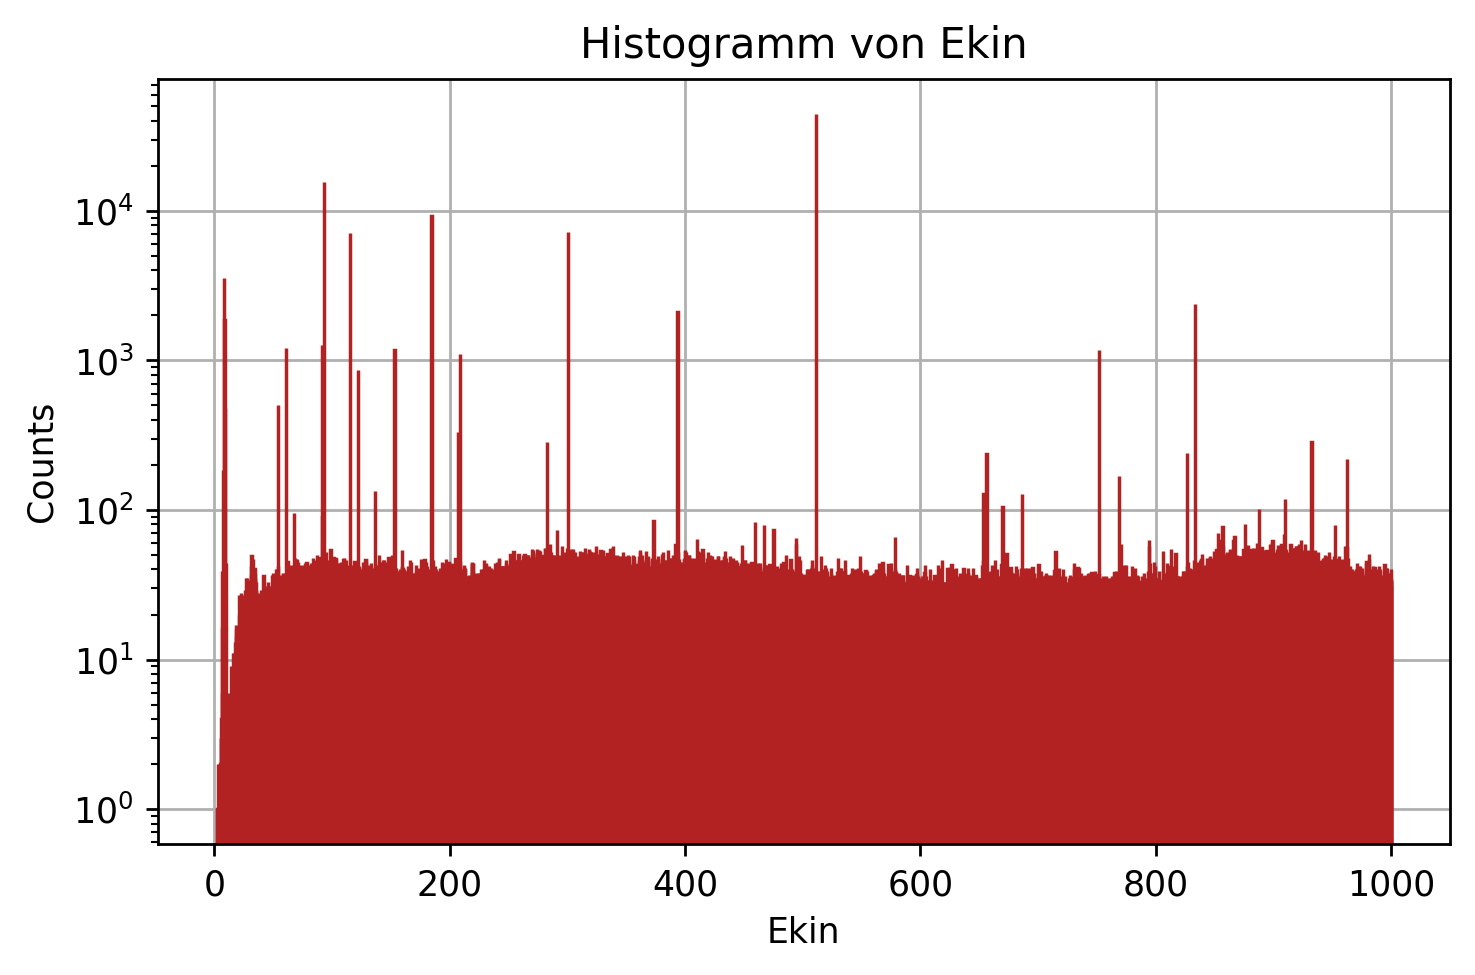

In [33]:
array_to_histo(data)

In [8]:
xy.xray_transition_energy_eV(25, 'La1')

637.0